<a href="https://colab.research.google.com/github/ShudraRuslan/DSSLab4/blob/main/%D0%A8%D1%83%D0%B4%D1%80%D0%B0%D0%9A%D0%9086_%D0%9B%D0%B0%D0%B14_%D0%A1%D0%9F%D0%9F%D0%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Практикум 4 Шудра Руслан Варіант 27

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import glob 
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.color import rgb2grey
from skimage.transform import resize

Загрузим набор картинок и обработаем его для дальнейшего использования

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2021-05-22 09:15:40--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  19.1MB/s    in 16s     

2021-05-22 09:15:56 (16.8 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
!unzip GTSRB_Final_Training_Images.zip

In [ ]:
num_classes= 43
data_path = 'GTSRB/Final_Training/Images'
images_list = []
image_labels = []
for i in range(num_classes):
    image_path = data_path + '/' + format(i, '05d') + '/'
    for img in glob.glob(image_path + '*.ppm'):
        image = cv2.imread(img)
        image = image/255
        image = resize(image, (32, 32))
        images_list.append(image)
       
        labels = np.zeros((num_classes, ), dtype=np.float32)
        labels[i] = 1.0
        image_labels.append(labels)
images = np.stack([img[:, :, :] for img in images_list], axis=0).astype(np.float32)
image_labels = np.matrix(image_labels).astype(np.int32)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]


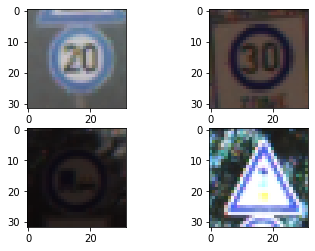

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(images[100, :, :] )
axes[0,1].imshow(images[1000, :, :] )
axes[1,0].imshow(images[16000, :, :] )
axes[1,1].imshow(images[30000, :, :])
print(image_labels[100, :])
print(image_labels[1000, :])
print(image_labels[16000, :])
print(image_labels[30000, :])

Проведем разбиение на обучающее и тестовое можества

In [ ]:
X= images.reshape(images.shape[0],-1)
train_X, test_X, train_y, test_y = train_test_split(X, image_labels,test_size=0.1)


Определим функцию вывода графиков для проверки качества обучения

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

def plotMetricsDependencyCode(train_X, train_y,model, 
                          callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0)):
  history=model.fit(train_X,train_X,epochs=10,batch_size=20,callbacks=callback,
                    validation_split=0.2,verbose=1)
  num_epochs = np.arange(0, len(history.history['loss']))
  plt.figure(dpi=200)

  plt.plot(num_epochs, history.history['val_loss'], label='val_loss', c='blue')
  plt.plot(num_epochs, history.history['loss'], label='train_loss', c='red')
  plt.title('Training and Validation Loss ')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

Выполним задачу семантического хеширования (4 пункт). Для начала построим модель глубокого автокодировщика

In [ ]:


def modelBuilderCode(coding_neurons):
  model = tf.keras.Sequential(
      
      [tf.keras.layers.Dense(128, activation = 'elu')] +\
      [tf.keras.layers.Dense(64, activation = 'elu')] +\
      [tf.keras.layers.Dense(coding_neurons, activation = 'sigmoid', name = 'code')] +\
      [tf.keras.layers.Dense(64, activation = 'elu')] +\
      [tf.keras.layers.Dense(128, activation = 'elu')] +\
      [tf.keras.layers.Dense(3072)]

  )
  model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mse"]
    )
  return model

Определим оптимальное количество нейронов на кодирующем шаре

Epoch 1/10
1412/1412 [==============================] - 8s 3ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

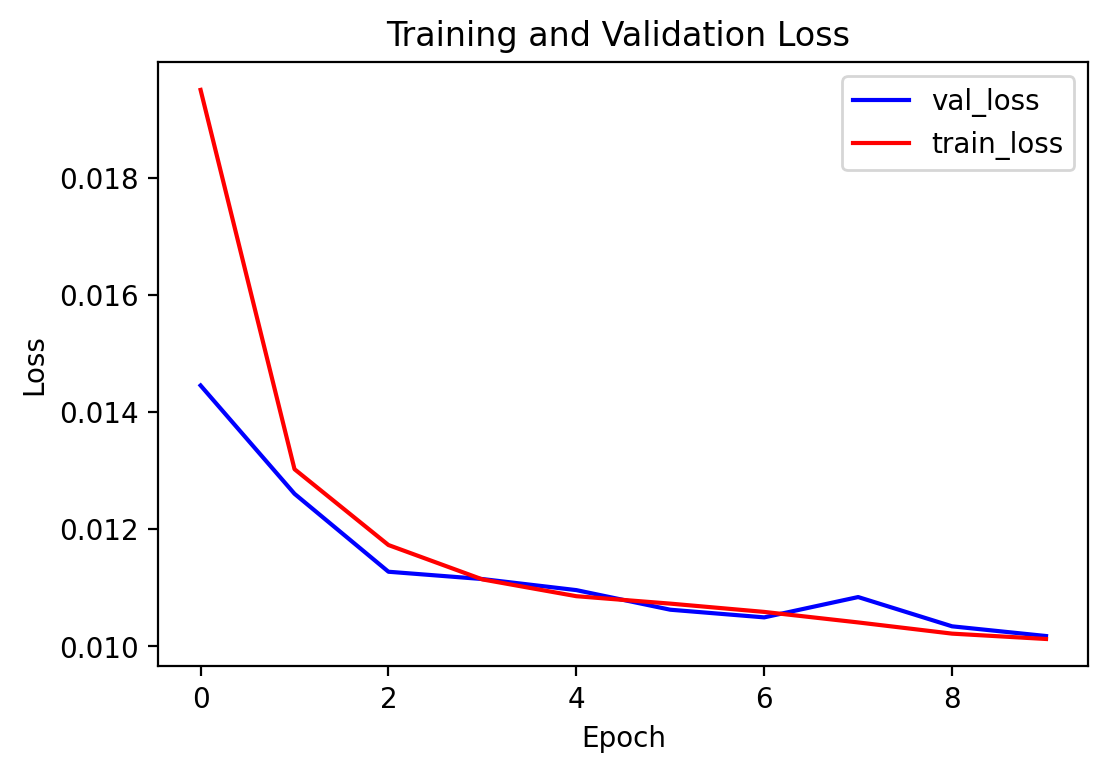

In [ ]:
coding_model_20 = modelBuilderCode(coding_neurons=20)
plotMetricsDependencyCode(train_X,train_X,coding_model_20)

Epoch 1/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 5/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

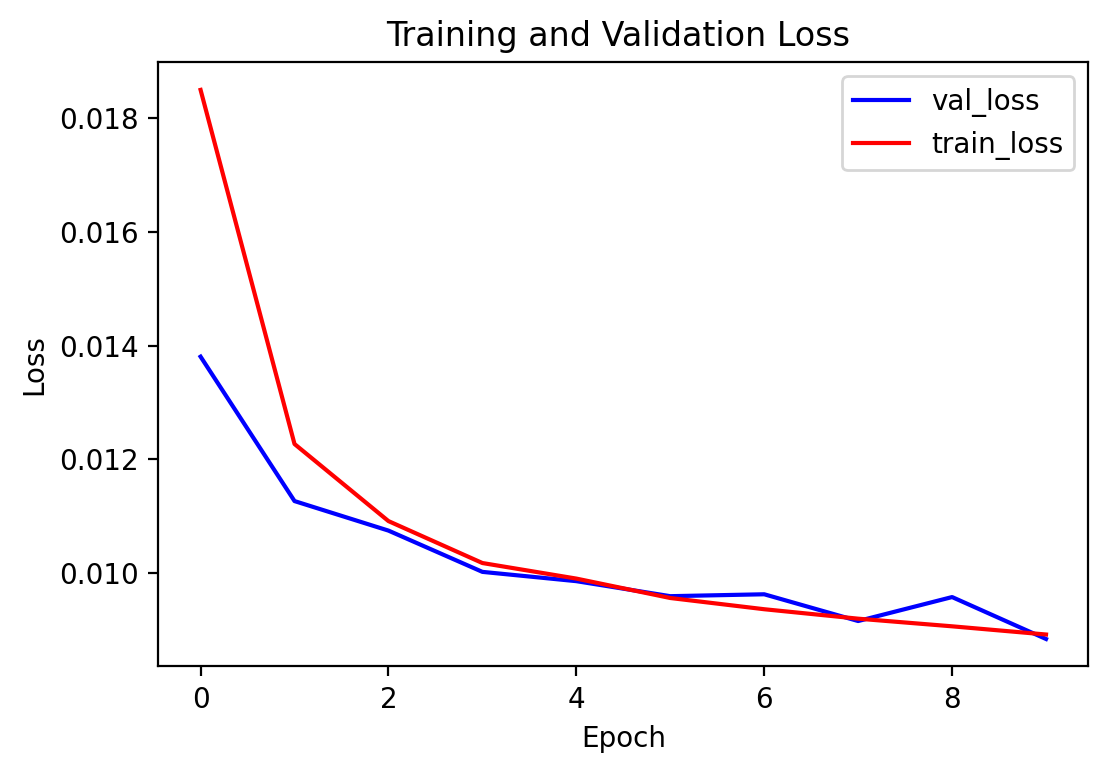

In [ ]:
coding_model_30 = modelBuilderCode(coding_neurons=30)
plotMetricsDependencyCode(train_X,train_X,coding_model_30)

Epoch 1/10
1412/1412 [==============================] - 7s 3ms/step - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

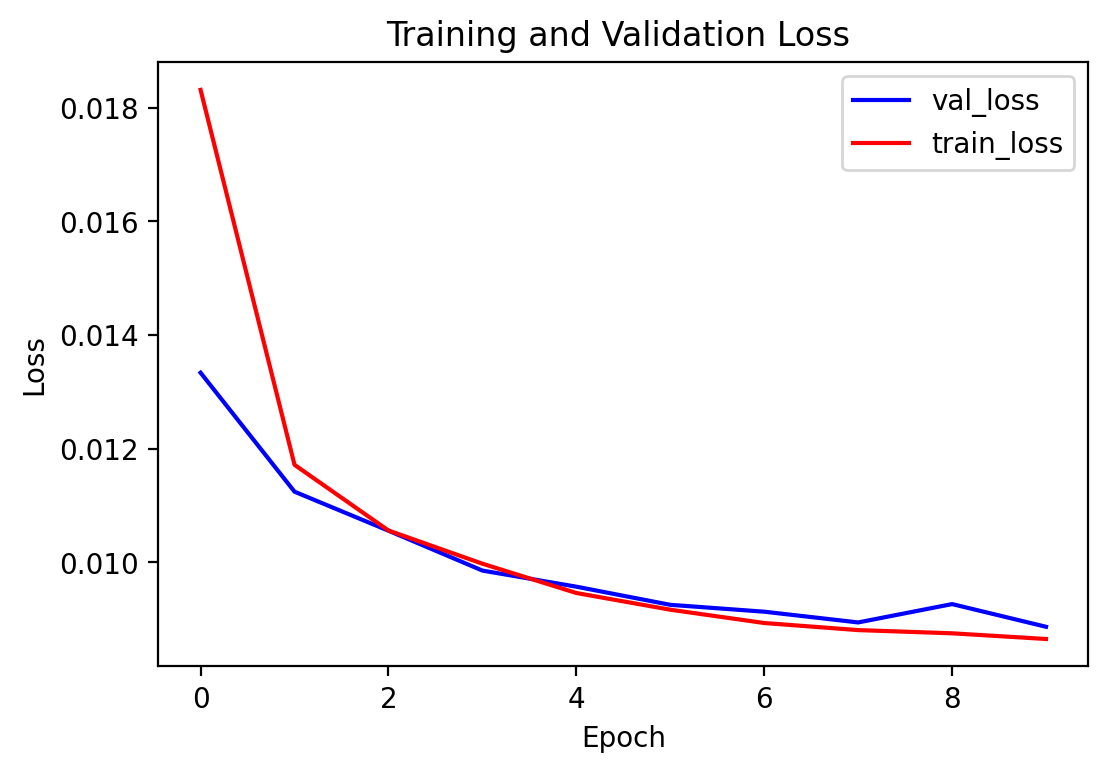

In [ ]:
coding_model_40 = modelBuilderCode(coding_neurons=40)
plotMetricsDependencyCode(train_X,train_X,coding_model_40)

Выберем найлучшую модель(с 40 нейронами), реконструируем и получим хеш изображения из тестового набора

In [ ]:
predict = coding_model_40.predict(test_X)

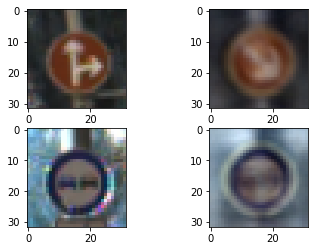

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(test_X[100, :].reshape(32,32,3) )
axes[0,1].imshow(predict[100, :].reshape(32,32,3) )
axes[1,0].imshow(test_X[200, :].reshape(32,32,3))
axes[1,1].imshow(predict[200, :].reshape(32,32,3))

In [ ]:
code_out = coding_model_40.get_layer("code").output
code_model = tf.keras.Model(coding_model_40.input, [code_out])
code = code_model.predict(test_X)

In [ ]:
code = np.round(code)

Теперь добавим ко входам учебного набора гауссовский шум и найдем оптимальную модель

In [ ]:
X_train_with_noise = train_X + (np.random.normal(0,0.2))/255


Epoch 1/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 5/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

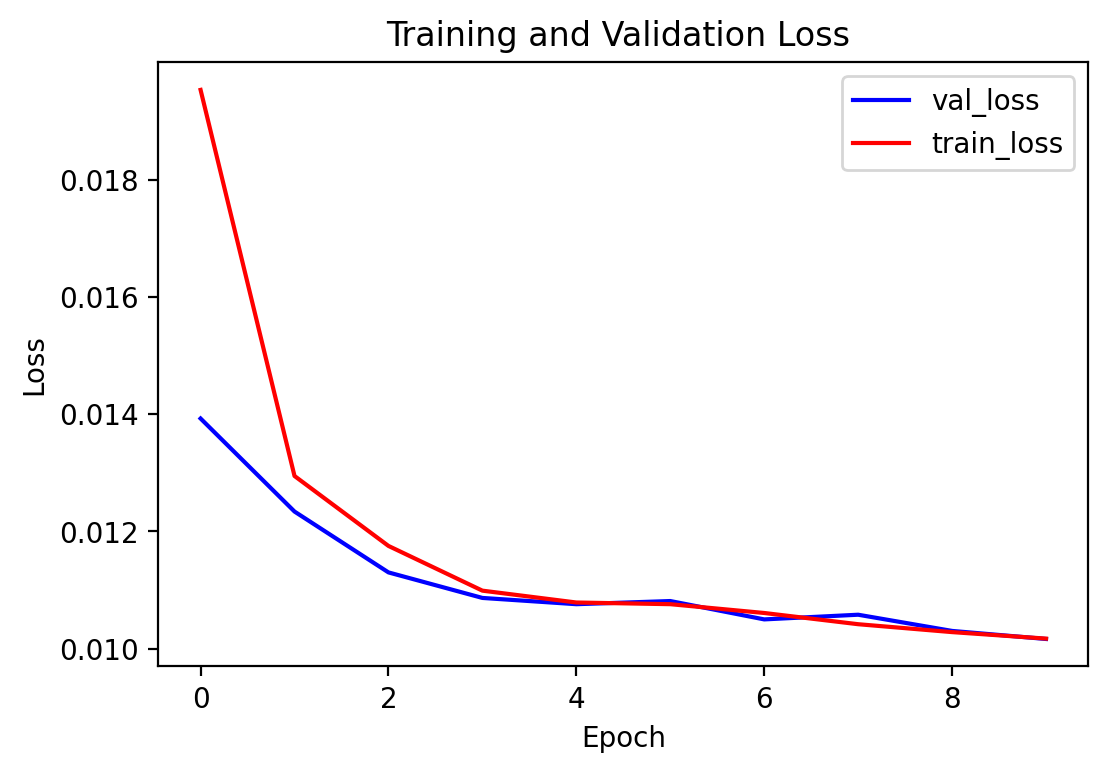

In [ ]:
coding_model_20_noise = modelBuilderCode(coding_neurons=20)
plotMetricsDependencyCode(X_train_with_noise,train_X,coding_model_20_noise)

Epoch 1/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

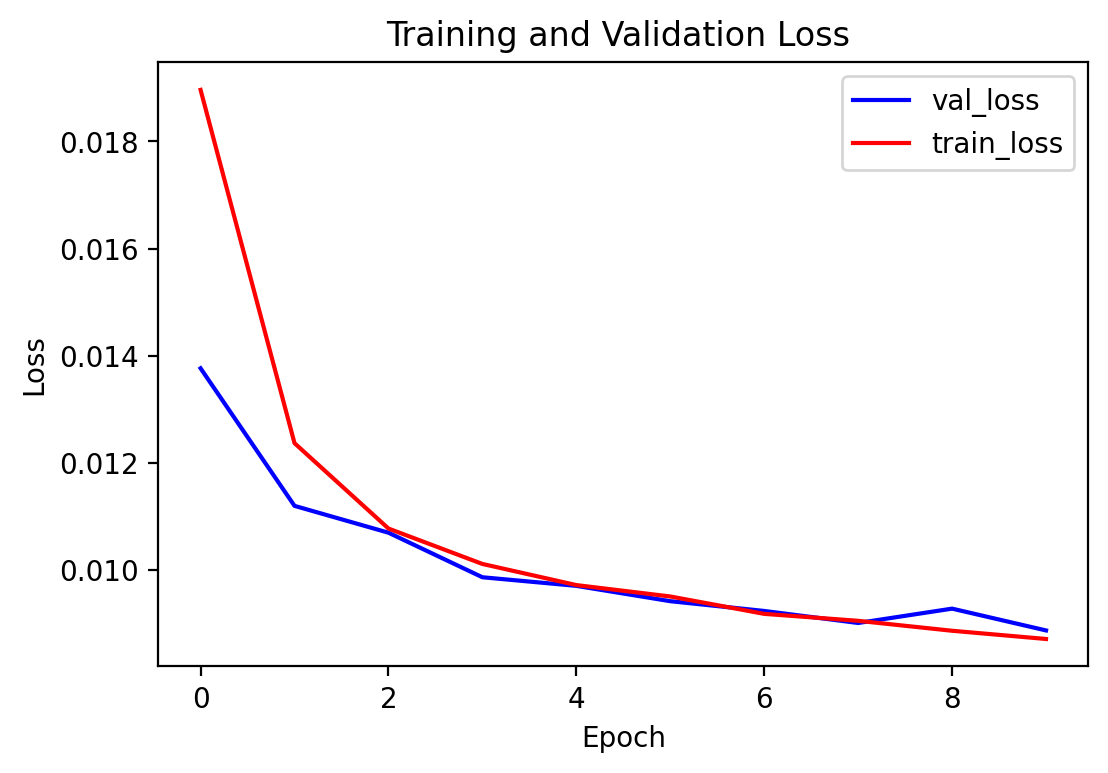

In [ ]:
coding_model_30_noise = modelBuilderCode(coding_neurons=30)
plotMetricsDependencyCode(X_train_with_noise,train_X,coding_model_30_noise)

Epoch 1/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 5/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

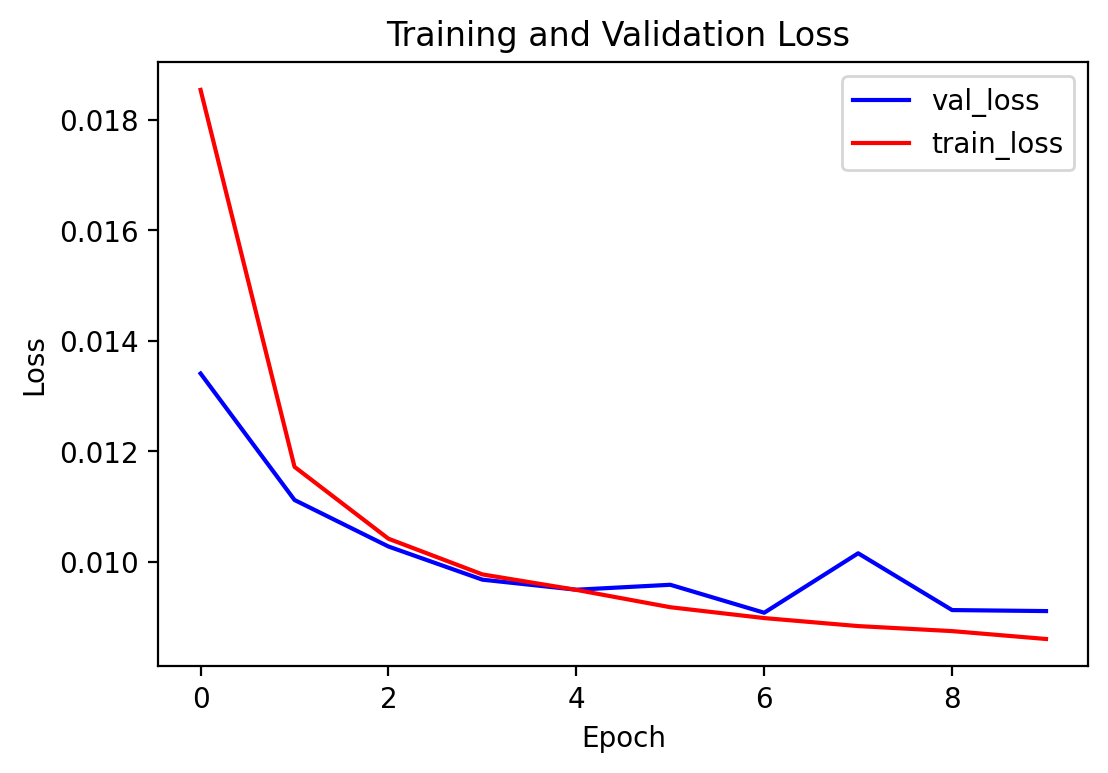

In [ ]:
coding_model_40_noise = modelBuilderCode(coding_neurons=40)
plotMetricsDependencyCode(X_train_with_noise,train_X,coding_model_40_noise)

In [ ]:
predict_noise = coding_model_40_noise.predict(test_X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


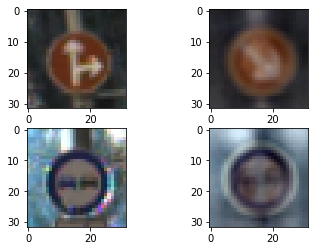

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(test_X[100, :].reshape(32,32,3) )
axes[0,1].imshow(predict_noise[100, :].reshape(32,32,3) )
axes[1,0].imshow(test_X[200, :].reshape(32,32,3) )
axes[1,1].imshow(predict_noise[200, :].reshape(32,32,3))

In [ ]:
code_out_noise = coding_model_40_noise.get_layer("code").output
code_model_noise = tf.keras.Model(coding_model_40_noise.input, [code_out_noise])
code_noise = code_model_noise.predict(test_X)

In [ ]:
code_noise = np.round(code_noise)


Сравним хеши, полученные моделями с и без шума

In [ ]:
print(code[0])
print(code_noise[0])

[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]


In [ ]:
print(code[1])
print(code_noise[1])

[1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]


Оценим количество одинаковых хешей

In [ ]:
from collections import Counter
def unique_hashes(array):
  list=[]
  for i in array:
    string = ''
    for j in i:
      string+=" "
      string+=str(j)
    
    list.append(string)
  myDict=Counter(list);
  return myDict

In [ ]:
print("Test set size", test_X.shape[0])
dict_hashes = unique_hashes(code)
print("Different hashes size", len(dict_hashes.keys()))

Test set size 3921
Different hashes size 2060


In [ ]:
print("Test set with noise size",test_X.shape[0])
dict_hashes_noise = unique_hashes(code_noise)
print("Different hashes with noise size", len(dict_hashes_noise.keys()))

Test set with noise size 3921
Different hashes with noise size 2200


Определим функцию нахождения нескольких изображений с одинаковым хешем

In [ ]:
def get_image_indexes_with_same_hash(code, dict_hashes, index):
  image_indexes=[]
  code_string = []

  for i in code:
    string = ""
    for j in i:
      string+=" "
      string+= str(j)
    code_string.append(string)
  
  code_string = np.asarray(code_string,dtype=str)

  hashes = list(dict_hashes.keys())
  hash_indexes = []

  for i in hashes:
    if dict_hashes[i]>1:
      hash_indexes.append(i)

  image_indexes = np.argwhere(code_string==hash_indexes[index])
  print(image_indexes)
  return image_indexes


Определим функцию подсчета меры Джини

In [ ]:
from collections import defaultdict

In [ ]:
def giniForIndexes(indexes, Y):
  Ys = np.argmax([Y[i] for i in indexes], axis=1)
  yGrouped = defaultdict(lambda: 0)
  for y in Ys:
    yGrouped[y] += 1
  return 1. - np.sum(list(map(lambda x: (x / len(indexes)) ** 2, yGrouped.values())))

Посмотрим на изображения с одинаковым хешем

In [ ]:
image_indexes = get_image_indexes_with_same_hash(code,dict_hashes,0)


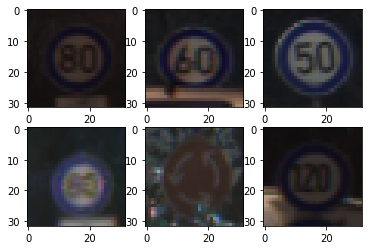

In [ ]:
fig, axes = plt.subplots(2, 3)
axes[0,0].imshow(test_X[image_indexes[0], :].reshape(32,32,3) )
axes[0,1].imshow(test_X[image_indexes[1], :].reshape(32,32,3) )
axes[0,2].imshow(test_X[image_indexes[2], :].reshape(32,32,3) )
axes[1,0].imshow(test_X[image_indexes[3], :].reshape(32,32,3) )
axes[1,1].imshow(test_X[image_indexes[4], :].reshape(32,32,3))
axes[1,2].imshow(test_X[image_indexes[5], :].reshape(32,32,3))

Определим меру Джини

In [ ]:
def giniForIndexes(indexes, Y):
  Ys = np.argmax([Y[i] for i in indexes], axis=1)
  yGrouped = defaultdict(lambda: 0)
  for y in Ys[0]:
    yGrouped[y] += 1
  return 1. - np.sum(list(map(lambda x: (x / len(indexes)) ** 2, yGrouped.values())))

In [ ]:
giniForIndexes(image_indexes, test_y)

0.9986630281364246

In [ ]:
image_indexes_noise = get_image_indexes_with_same_hash(code_noise, dict_hashes_noise)

''

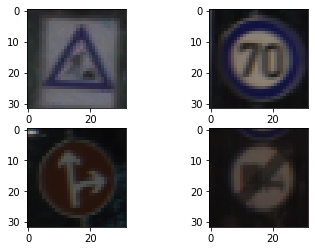

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(test_X[image_indexes_noise[0], :].reshape(32,32,3) )
axes[0,1].imshow(test_X[image_indexes_noise[1], :].reshape(32,32,3) )
axes[1,0].imshow(test_X[image_indexes_noise[2], :].reshape(32,32,3) )
axes[1,1].imshow(test_X[image_indexes_noise[3], :].reshape(32,32,3))
,

Приступим к выполнению второго пункта задания. Создадим функцию построения модели

In [ ]:
def modelBuilder(layers = [100, 50, 45]):
    model = tf.keras.Sequential(
        [tf.keras.layers.Dropout(0.2)] + \
        list(map(lambda s: tf.keras.layers.Dense(s, activation="elu"), layers)) +\
        [tf.keras.layers.Dense(40, activation="elu", name="code")] + \
        list(map(lambda s: tf.keras.layers.Dense(s, activation="elu"), layers[::-1])) +\
        [tf.keras.layers.Dense(3072)]
    )
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mse"]
    )
    return model

Подберем найлучшее количество нейронов в слоях

Epoch 1/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 2/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 3/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 5/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

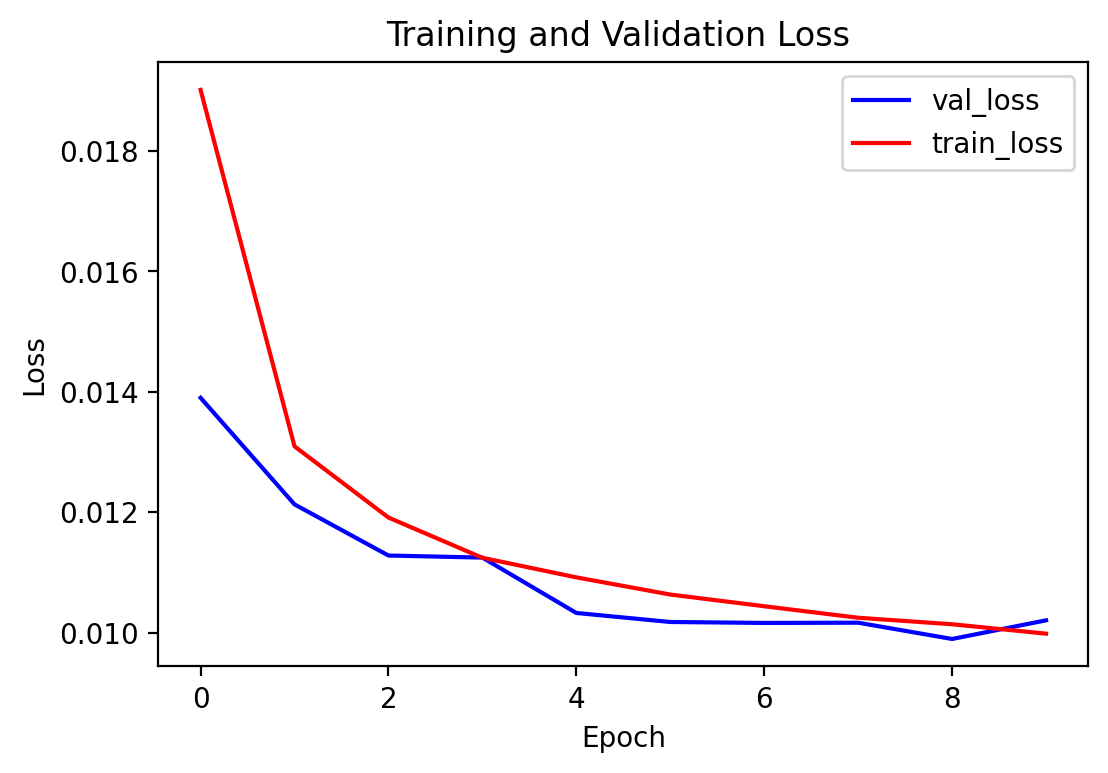

In [ ]:
restore_model1 = modelBuilder()
plotMetricsDependencyCode(train_X,train_X,restore_model1)

Epoch 1/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 8/10
1412/1412 [==============================] - 5s 3ms

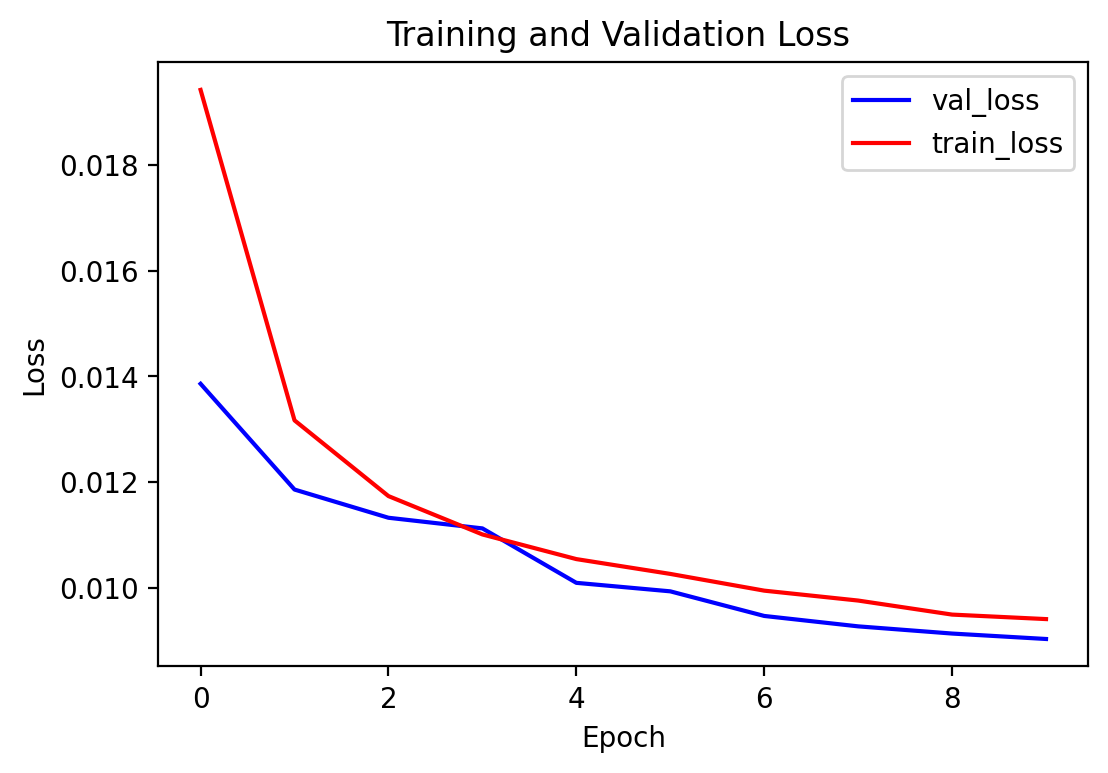

In [ ]:
restore_model2 = modelBuilder(layers=[50,100,150])
plotMetricsDependencyCode(train_X,train_X,restore_model2)

Epoch 1/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 2/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 3/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 4/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 5/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6/10
1412/1412 [==============================] - 5s 3ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7/10
1412/1412 [==============================] - 4s 3ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 8/10
1412/1412 [==============================] - 4s 3ms

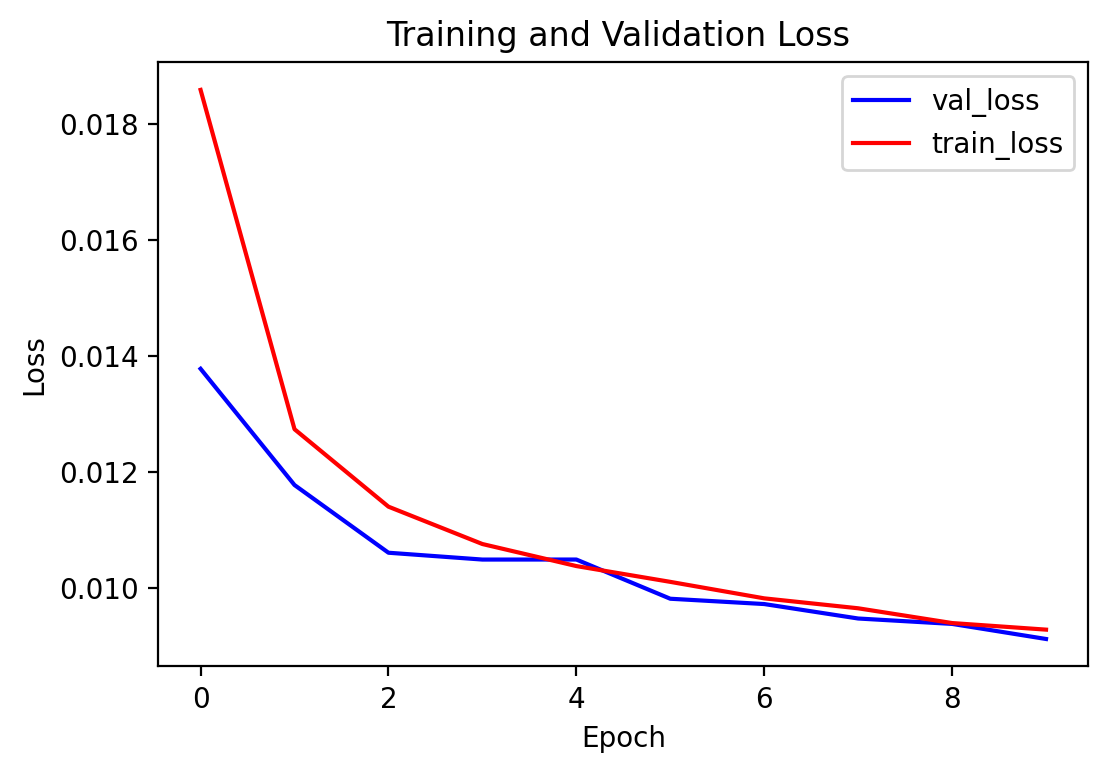

In [ ]:
restore_model3 = modelBuilder(layers=[60,120,200])
plotMetricsDependencyCode(train_X,train_X,restore_model3)

Сделаем реконструкцию лучшей моделью

In [ ]:
restore = restore_model2.predict(test_X)

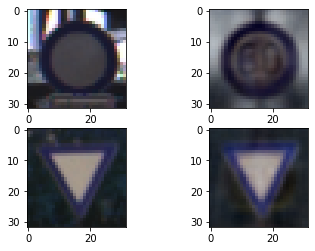

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(test_X[0, :].reshape(32,32,3) )
axes[0,1].imshow(restore[0, :].reshape(32,32,3) )
axes[1,0].imshow(test_X[1, :].reshape(32,32,3) )
axes[1,1].imshow(restore[1, :].reshape(32,32,3))


Выведем полученные низкоуровневые признаки этих двух изображений

In [ ]:
print(restore[0])
print(restore[1])

[0.52675676 0.54557383 0.5802011  ... 0.21186048 0.23751554 0.25940934]
[0.13120496 0.16456358 0.19763616 ... 0.14080712 0.16288082 0.18429339]


Попробуем использовать нижние слои модели для классификации

In [ ]:
restore_model2.trainable = False

restore_model2.pop()
restore_model2.pop()
restore_model2.pop()
restore_model2.pop()

In [ ]:
def modelBuilderTransfer():
    model = tf.keras.Sequential(
        [restore_model2] + \
        [tf.keras.layers.Dense(100, activation="relu")] + \
        [tf.keras.layers.Dense(200, activation="relu")] + \
        [tf.keras.layers.Dense(300, activation="relu")] + \
        [tf.keras.layers.Dense(400, activation="relu")] + \
        [tf.keras.layers.Dense(num_classes)]

    )
    model.compile(
        optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1),
        loss= 'mse',
        metrics=["accuracy"]
    )
    return model

In [ ]:
def plotMetricsDependency(train_X,train_Y,model, 
                          callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0)):
  history=model.fit(train_X,train_Y,epochs=20,batch_size=20,callbacks=callback,
                    validation_split=0.1,verbose=1)
  num_epochs = np.arange(0, len(history.history['accuracy']))
  plt.figure(dpi=200)

  plt.plot(num_epochs, history.history['accuracy'], label='train_acc', c='green')
  plt.plot(num_epochs, history.history['val_loss'], label='val_loss', c='orange')
  plt.plot(num_epochs, history.history['val_accuracy'], label='val_acc', c='blue')
  plt.plot(num_epochs, history.history['loss'], label='train_loss', c='red')
  plt.title('Training Loss and Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss/Accuracy')
  plt.legend()

Epoch 1/20
1588/1588 [==============================] - 5s 3ms/step - loss: 0.0263 - accuracy: 0.1570 - val_loss: 0.0208 - val_accuracy: 0.3140
Epoch 2/20
1588/1588 [==============================] - 4s 3ms/step - loss: 0.0206 - accuracy: 0.3196 - val_loss: 0.0197 - val_accuracy: 0.3565
Epoch 3/20
1588/1588 [==============================] - 4s 3ms/step - loss: 0.0196 - accuracy: 0.3629 - val_loss: 0.0190 - val_accuracy: 0.3857
Epoch 4/20
1588/1588 [==============================] - 4s 3ms/step - loss: 0.0189 - accuracy: 0.3910 - val_loss: 0.0184 - val_accuracy: 0.4083
Epoch 5/20
1588/1588 [==============================] - 4s 3ms/step - loss: 0.0184 - accuracy: 0.4106 - val_loss: 0.0180 - val_accuracy: 0.4222
Epoch 6/20
1588/1588 [==============================] - 4s 3ms/step - loss: 0.0180 - accuracy: 0.4271 - val_loss: 0.0176 - val_accuracy: 0.4435
Epoch 7/20
1588/1588 [==============================] - 4s 3ms/step - loss: 0.0177 - accuracy: 0.4361 - val_loss: 0.0173 - val_accuracy:

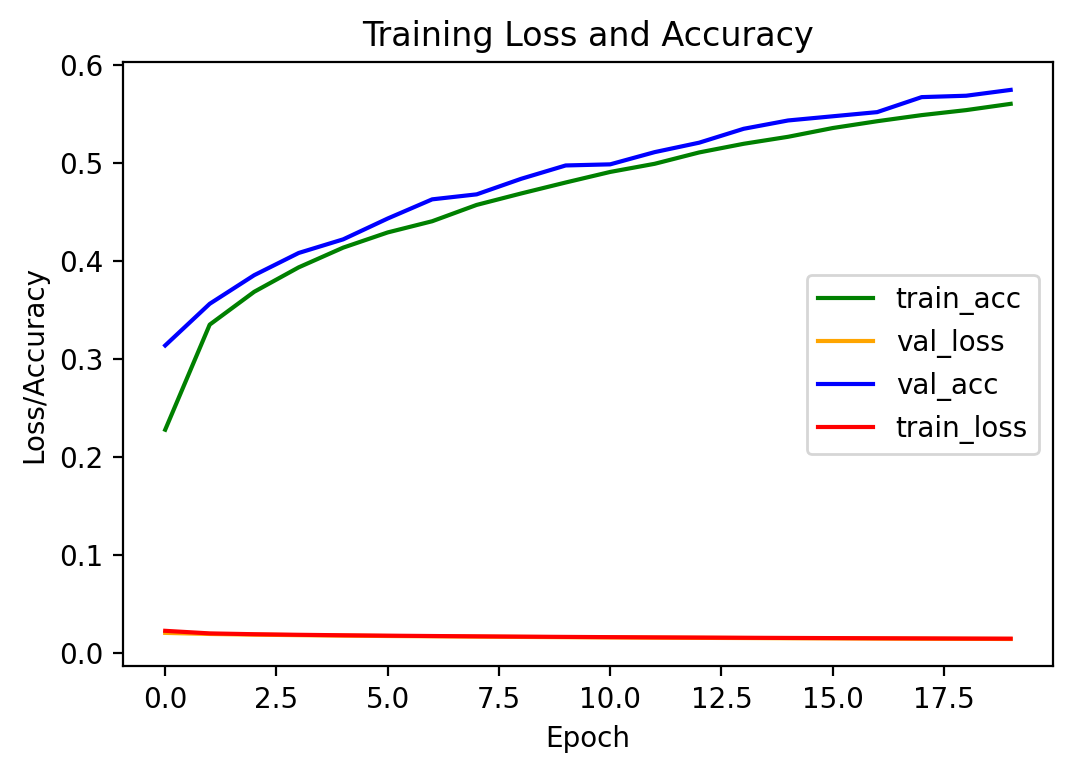

In [ ]:
transfer_model = modelBuilderTransfer()
plotMetricsDependency(train_X, train_y, transfer_model)